**Diffusion Limited Aggregation**
![SegmentLocal](../Material/Brownian_tree.gif "DLA")

Diffusion limited aggregation is a process in which particles randomly walking, come close enough the already existing particles in the region that they stick (*Stickiness* : A hyperparameter that can be varied). Now these particles follow a random motion, called Broiwnian Motion.

For the purpose of simulation, the surface is considered to be a canvas of MxM dimensions [A matrix], initialised to all zero, but one, that is the centre most point in the plane. Thats the particle, with which the aggregation begins, the particle spawning in random in the proximity start a random walk in the canvas and when it comes in the proximity of an existing particle in the aggregation, it gets stuck at it, becoming a part of that aggregation. Then a new particle will spawn, following the same procedure, shall it find its place in the aggregation, attaching itself to the already existing aggregation and the process goes on till each particle has found its place in the aggregation.

# Imports

In [19]:
# General
import numpy as np
import random
from IPython.display import clear_output
from tqdm import tqdm_notebook
tqdm_notebook()
import time
import matplotlib as mpl
from datetime import datetime
import pandas as pd
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Algorithms
from scipy.optimize import curve_fit
import statsmodels.api as sm


# Paths

In [74]:
# General
root_path = '../'
data_path = 'Data/'

# Prepared Data
prepared_data_path = 'Prepared Data/'
plotting_path = root_path+'Plots/'

aggregateTS = pd.DataFrame(columns=['Timestamp'])
plt.rcParams['figure.dpi'] = 180
plt.rcParams['figure.figsize'] = (25,15)

# DLA Simulations

In [75]:
class DLA:
    def __init__(self):

        self.instantiate(100, 2000, mode='Default')

    def instantiate(self, _shape, _particles, mode='Custom', verbose=False):

        self.canvas_mode = mode
        self.shape = _shape
        self.particles = _particles

        self.canvas = np.zeros([self.shape, self.shape])
        self.canvas[int(self.shape/2)][int(self.shape/2)] = 1

        # length : 4(n-1)
        self.boundary_points = [(w, h) for w in [0, self.shape-1] for h in range(0, self.shape)]
        self.boundary_points += [(h, w) for w in [0, self.shape-1] for h in range(0, self.shape)]
        self.boundary_points = set(self.boundary_points)
        self.boundary_points = [list(e) for e in self.boundary_points]
        self.cache = []
        if verbose:
            print('Number of Spawning points for a player : ', len(self.boundary_points))

    def spawnParticle(self):

        if self.boundary_points == []:
            spawnIdx = -999
            return spawnIdx
        spawnIdx = random.choice(self.boundary_points)

        while self.canvas[spawnIdx[0], spawnIdx[1]] != 0:

            spawnIdx = random.choice(self.boundary_points)

        return spawnIdx

    def checkState(self, idx, _stck):

        allProximities = set([(idx[0]+i, idx[1]+e) for i in [0, 1, -1] for e in [0, 1, -1]])
        allProximities = [list(e) for e in allProximities if e != tuple(
            idx) if (0 <= e[0] < self.shape) and (0 <= e[1] < self.shape)]
        allVacantProximities = [e for e in allProximities if self.canvas[e[0]][e[1]] == 0]

        if sum([self.canvas[e[0]][e[1]] for e in allProximities]) == 0:
            return True, random.choice(allProximities)
        else:
            if random.random() < _stck:
                return False, [-999, -999]
            else:
                if allVacantProximities != []:
                    return True, random.choice(allVacantProximities)
                else:
                    print('Nowhere to go!')
                    return False, [-999, -999]

    def initiate(self, stickiness=1):

        for eachParticles in tqdm_notebook(range(self.particles)):

            inMotion = True
            spawnP_Idx = self.spawnParticle()
            
            if spawnP_Idx == -999:
                print('No boundary point left. Terminating!')
                break

            self.canvas[spawnP_Idx[0], spawnP_Idx[1]] = 1

            while inMotion:

                inMotion, nextMove = self.checkState(spawnP_Idx, stickiness)

                if inMotion:
                    self.canvas[spawnP_Idx[0], spawnP_Idx[1]] = 0
                    self.canvas[nextMove[0], nextMove[1]] = 1
                    spawnP_Idx = nextMove

                else:
                    if spawnP_Idx in self.boundary_points:
                        self.boundary_points.remove(spawnP_Idx)
                        print(len(self.boundary_points))
                    break

            t = self.canvas.copy()
            aggregateTS.loc[eachParticles, 'Timestamp'] = datetime.now()
            self.cache.append(t)
            
        return self.cache

In [76]:
dlaSim = DLA()
p = 4000
s = 200

dlaSim.instantiate(s, p, verbose=True)
CACHE = dlaSim.initiate()


Number of Spawning points for a player :  796


795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751
750
749
748
747
746
745
744
743
742
741
740
739
738
737
736
735
734
733
732
731
730
729
728
727
726



# Simulation Animation

In [14]:
import matplotlib.animation as anim

class AnimatedGif:
    def __init__(self, size=(680, 520)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []

    def add(self, image, label='', _stck=-999):
        plt_im = plt.imshow(image, vmin=0, cmap = 'copper', vmax=1, animated=True)
        
        lbl = int(int(label)/100 * 100)
        if lbl == 0:
            lbl = ''
        plt_txt1 = plt.text(-30,10, lbl, fontsize=12, color='red')
        plt_txt2 = plt.text(210, 10, 'Stickiness : {0}'.format(_stck),fontsize=12, color='red')
        self.images.append([plt_im, plt_txt1, plt_txt2])

    def save(self, filename):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=200)

In [ ]:
m = 580
n = 320

animated_gif = AnimatedGif(size=(m, n))
images = []
for i in tqdm_notebook(range(len(CACHE))):
    
    animated_gif.add(CACHE[i], label=str(i), _stck = '1.0')

animated_gif.save('dla-animated_P4000_C200_S1_fps200.gif')


# DLA Time Dependence

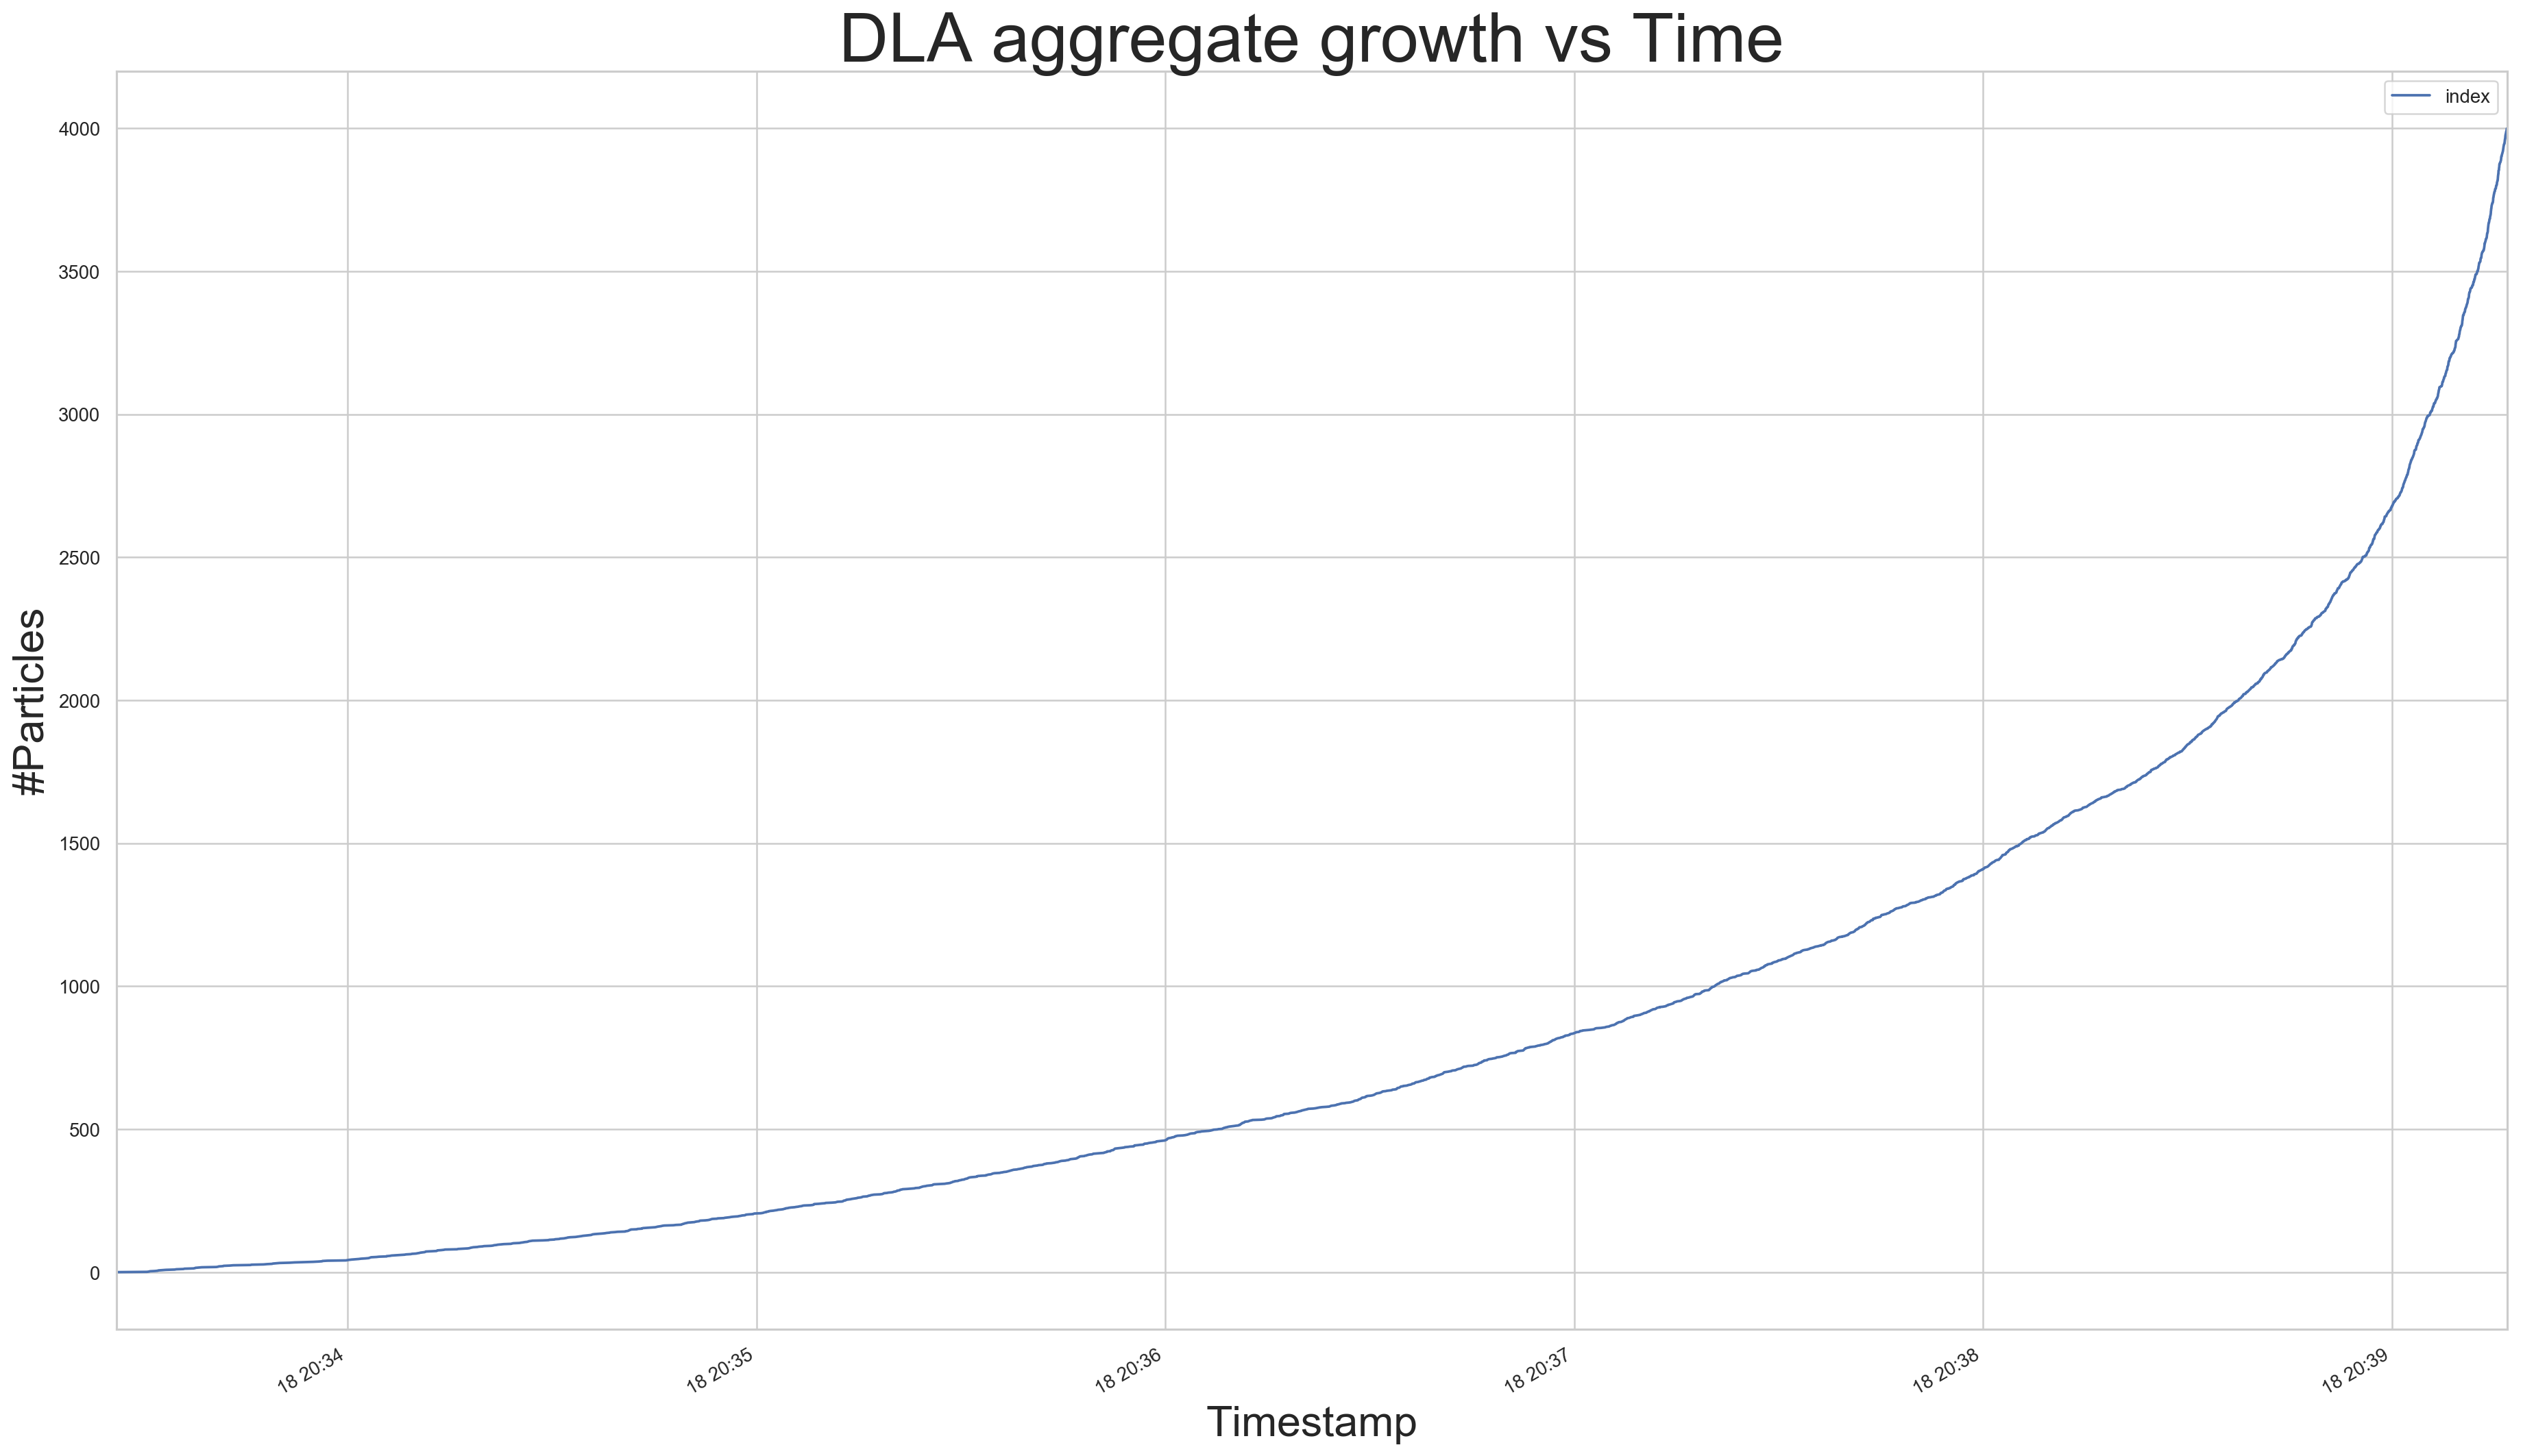

In [90]:
fig = aggregateTS.reset_index().set_index('Timestamp').plot()
_=fig.set_xlabel('Timestamp', fontsize=25)
_=fig.set_ylabel('#Particles', fontsize=25)
_=fig.set_title('DLA aggregate growth vs Time', fontsize=40)

plt.savefig(root_path+'Material/dlaTime.jpg', bbox_inches='tight')

# Random Testing Space

In [84]:
[k for k in fig.__dir__() if 'legend' in k]

['legend_', 'get_legend_handles_labels', 'legend', 'get_legend']

In [58]:
baseTS = aggregateTS.iloc[0,0]

In [65]:
(aggregateTS.iloc[300,0] - baseTS).microseconds

426285